# 동사무소 -> 집
---
1. 트럭
    - 속도: 30km/h
    - 대기 시간: 1.5min
    - osrm을 통한 경로 추출
2. 로봇
    - 여러 대 배치
    - 속도: 5.76km/h
    - ortools로 각 로봇마다의 경로 추출?(지나가는 집들 정해주기) 
    - 경로를 추출 했으면 osrm으로 경로 시각화

- 트럭과 로봇 전체 이용 가능한 OD 데이터 생성    
    - O: 동사무소 지점, D: 각 집들 지점


# 로봇 네트워크
---
- 12/09 피드백
    - from sub to dong / dong to homes 두 개 동시에 시각화

- 12/15 피드백
    - 주민센터 좌표로 변경
    - 관악구 신림동으로 변경

**기본 구성**
- sub - 집까지 직행 네트워크 
- 하나의 동만 정해서 sub부터 출발

**참고**
- 2번째 네트워크와 timestamp, 속도 맞춰줘야 함

**로봇 조건**
- 트럭으로 가는 네트워크가 동사무소까지에서 끝나면 그 시간 이후로 로봇 네트워크 시각화 되도록 수정
- 트럭과 로봇 속도 다르게 구성해야 함
- 로봇 이상 경로 존재했음 - 수정해줘야 함

동사무소를 시작으로 배달해야하는 집들을 모은 데이터

- O: 신림동 주민센터    
    37.487399, 126.927095
- O: 관악구 관할 sub 터미널   
    37.481974, 126.87877   

- D: 집들(20) = [   
    [126.928485, 37.487397],
    [126.927889, 37.486959],
    [126.928131, 37.485849],
    [126.928085, 37.486300],
    [126.928528, 37.486501],
    [126.928775, 37.485665],
    [126.928041, 37.485027],
    [126.927470, 37.484800],
    [126.927185, 37.484897],
    [126.926831, 37.484975],
    [126.927358, 37.485457],
    [126.928110, 37.486413],
    [126.926612, 37.486137],
    [126.926905, 37.486493],
    [126.926123, 37.486979],
    [126.925733, 37.487433],
    [126.925151, 37.486567],
    [126.925955, 37.486268],
    [126.925445, 37.485901],
    [126.925938, 37.485551] 
]

coordinates = [   
    (37.487397, 126.928485),
    (37.486959, 126.927889),
    (37.485849, 126.928131),
    (37.486300, 126.928085),
    (37.486501, 126.928528),
    (37.485665, 126.928775),
    (37.485027, 126.928041),
    (37.484800, 126.927470),
    (37.484897, 126.927185),
    (37.484975, 126.926831),
    (37.485457, 126.927358),
    (37.486413, 126.928110),
    (37.486137, 126.926612),
    (37.486493, 126.926905),
    (37.486979, 126.926123),
    (37.487433, 126.925733),
    (37.486567, 126.925151),
    (37.486268, 126.925955),
    (37.485901, 126.925445),
    (37.485551, 126.925938)
]


## 기본 OD 생성

In [58]:
# 라이브러리 불러오기
import numpy as np
import itertools
import requests
import polyline
import json
import os
import math

import random as rd
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

In [59]:
# 변수 설정

## O 데이터 (신림동 주민센터)
O = ['신림동 주민센터'] * 20
O_point = [[126.927095, 37.487399]] * 20  # 좌표 (longitude, latitude)

## D 데이터
D = [
    'home1', 'home2', 'home3', 'home4', 'home5', 'home6', 'home7', 'home8', 'home9', 'home10',
    'home11', 'home12', 'home13', 'home14', 'home15', 'home16', 'home17', 'home18', 'home19', 'home20'
]

# 주어진 좌표 리스트
coordinates = [   
    (37.487397, 126.928485),
    (37.486959, 126.927889),
    (37.485849, 126.928131),
    (37.486300, 126.928085),
    (37.486501, 126.928528),
    (37.485665, 126.928775),
    (37.485027, 126.928041),
    (37.484800, 126.927470),
    (37.484897, 126.927185),
    (37.484975, 126.926831),
    (37.485457, 126.927358),
    (37.486413, 126.928110),
    (37.486137, 126.926612),
    (37.486493, 126.926905),
    (37.486979, 126.926123),
    (37.487433, 126.925733),
    (37.486567, 126.925151),
    (37.486268, 126.925955),
    (37.485901, 126.925445),
    (37.485551, 126.925938)
]

# 변환된 결과 리스트
D_point = [[lon, lat] for lat, lon in coordinates]
# 좌표를 WKT 형식으로 변환
O_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in O_point]
D_point_wkt = [f"POINT ({coord[0]} {coord[1]})" for coord in D_point]

# 데이터프레임 구성
OD_data = pd.DataFrame({
    'O': O,
    'O_point': O_point_wkt,
    'D': D,
    'D_point': D_point_wkt
})

# 문자열을 Point 객체로 변환하는 함수
def convert_to_point(point_str):
    # 'POINT (127.127384 37.45091)' -> [127.127384, 37.45091]
    coords = point_str.replace("POINT (", "").replace(")", "").split()
    return Point(float(coords[0]), float(coords[1]))

# 'start_point'와 'end_point'를 Point 객체로 변환
OD_data['O_point'] = OD_data['O_point'].apply(convert_to_point)
OD_data['D_point'] = OD_data['D_point'].apply(convert_to_point)

In [60]:
OD_data.to_csv("data/OD_data.csv")

## 기본 함수 불러오기

## 로봇 OD 경로 생성

In [61]:
# 로봇 데이터프레임 구성하기

# 변수 설정하기
## 로봇 데이터
speed = [5.76] * 20
duration = [0] * 20
distance = [0] * 20

# 데이터프레임 구성하기
OD_data_robot = OD_data.copy()
OD_data_robot['speed(km/h)'] = speed
OD_data_robot['duration'] = duration
OD_data_robot['distance'] = distance

In [62]:
OD_data_robot

,O,O_point,D,D_point,speed(km/h),duration,distance
0,신림동 주민센터,POINT (126.927095 37.487399),home1,POINT (126.928485 37.487397),5.76,0,0
1,신림동 주민센터,POINT (126.927095 37.487399),home2,POINT (126.927889 37.486959),5.76,0,0
2,신림동 주민센터,POINT (126.927095 37.487399),home3,POINT (126.928131 37.485849),5.76,0,0
3,신림동 주민센터,POINT (126.927095 37.487399),home4,POINT (126.928085 37.4863),5.76,0,0
4,신림동 주민센터,POINT (126.927095 37.487399),home5,POINT (126.928528 37.486501),5.76,0,0
5,신림동 주민센터,POINT (126.927095 37.487399),home6,POINT (126.928775 37.485665),5.76,0,0
6,신림동 주민센터,POINT (126.927095 37.487399),home7,POINT (126.928041 37.485027),5.76,0,0
7,신림동 주민센터,POINT (126.927095 37.487399),home8,POINT (126.92747 37.4848),5.76,0,0
8,신림동 주민센터,POINT (126.927095 37.487399),home9,POINT (126.927185 37.484897),5.76,0,0
9,신림동 주민센터,POINT (126.927095 37.487399),home10,POINT (126.926831 37.484975),5.76,0,0


## ortools 사용하기

> ortools를 사용하여 로봇 대수에 따른 각 로봇의 할당 경로 추출   
> 경로 추출 후: osrm으로 경로 시각화

---

### 데이터 준비
`od_data_for_ortools`
- point: 지점명
- point_coord: 지점 좌표(경, 위도)

`calculate_straight_distance` 함수
- 직선 거리 계산 함수    
- 출력값: O-D 사이의 직선 거리(m) 반환

`distance_matrix` 
- od_data_for_ortools 의 point_coord에서 공백과 괄호 제거 후 위도, 경도로 나누기
- caluate_straight_distance 함수를 통해
- 모든 지점 끼리의 거리 행렬 생성

---
로봇 수요량을 임의로 정해서 용량 제한 차량 배치함
- 테스트 상태(돌아가는 지만 확인함)
- 용량말고 시간이나 거리 제한이 가능한지 공부 후 수정 필요
- 용량과 총량은 랜덤으로 돌림
- 로봇 수 3대로 가정

In [63]:
# ortools 사용하기 위한 라이브러리
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

data 모델 만들기 
- `distance_matrix`: 노드 간의 거리를 행렬로 표현
    - 주민센터와 home들의 각각 osrm으로 거리를 추출하여 저장
- `demands`: 각 노드 요구량
    - 각 home들의 요구량을 설정해주기
    - 집들을 전제로 하므로 무게 개념으로 가야할 듯
- `vehicle_capacities`: 각 로봇의 용량
    - demands 설정 값에 따라 달라짐
- `num_vehicle`: 로봇 대수
 - `depot`: 출발지 및 도착지 (기본 노드 0)
    - 출발지 = 도착지 = 주민센터 위치

In [64]:
# 데이터 준비
data = {
    "point": ["신림동 주민센터"] + [f"home{i}" for i in range(1, 21)],
    "point_coord": [
        "POINT (126.927095 37.487399)"
    ] + [
        'POINT (126.928485 37.487397)',
        'POINT (126.927889 37.486959)',
        'POINT (126.928131 37.485849)',
        'POINT (126.928085 37.4863)',
        'POINT (126.928528 37.486501)',
        'POINT (126.928775 37.485665)',
        'POINT (126.928041 37.485027)',
        'POINT (126.92747 37.4848)',
        'POINT (126.927185 37.484897)',
        'POINT (126.926831 37.484975)',
        'POINT (126.927358 37.485457)',
        'POINT (126.92811 37.486413)',
        'POINT (126.926612 37.486137)',
        'POINT (126.926905 37.486493)',
        'POINT (126.926123 37.486979)',
        'POINT (126.925733 37.487433)',
        'POINT (126.925151 37.486567)',
        'POINT (126.925955 37.486268)',
        'POINT (126.925445 37.485901)',
        'POINT (126.925938 37.485551)'
    ],
}

# DataFrame 생성
od_data_for_ortools = pd.DataFrame(data)

# DataFrame 확인
od_data_for_ortools

,point,point_coord
0,신림동 주민센터,POINT (126.927095 37.487399)
1,home1,POINT (126.928485 37.487397)
2,home2,POINT (126.927889 37.486959)
3,home3,POINT (126.928131 37.485849)
4,home4,POINT (126.928085 37.4863)
5,home5,POINT (126.928528 37.486501)
6,home6,POINT (126.928775 37.485665)
7,home7,POINT (126.928041 37.485027)
8,home8,POINT (126.92747 37.4848)
9,home9,POINT (126.927185 37.484897)


In [65]:
# 직선 거리 계산 함수
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    '''
    좌표 거리 생성 함수 
    - 직선 거리 계산 
    - 경로를 모르는 경우 두 지점 간의 대략적인 직선 거리를 계산할 때 사용

    입력값:
        lat1: 출발지 위도 (float)
        lon1: 출발지 경도 (float)
        lat2: 도착지 위도 (float)
        lon2: 도착지 경도 (float)

    출력값:
        두 지점 간의 직선 거리 (미터 단위, float)
    '''
# 직선 거리 계산
# 입력값: 출발지 위도, 경도 / 도착지 위도, 경도
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 # 도착지 위도 - 출발지 위도
    dlon = lon2 - lon1 # 도착지 경도 - 출발지 경도

    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (미터 단위)
    km = km_constant * c
    m = km * 1000
    
    return m # 출발지-도착지 사이의 직선 거리 반환

In [66]:
# 좌표 분리 (공백과 괄호 제거 후 나누기) - 위도, 경도 분리
od_data_for_ortools["longitude"], od_data_for_ortools["latitude"] = zip(
    *od_data_for_ortools["point_coord"].str.replace("POINT ", "").str.replace("[()]", "", regex=True).str.split(" ").apply(lambda x: map(float, x))
)

# 거리 행렬 생성
distance_matrix = pd.DataFrame(index=od_data_for_ortools["point"], columns=[f"{p}_dist" for p in od_data_for_ortools["point"]])

# 거리 계산
for i, row1 in od_data_for_ortools.iterrows():
    for j, row2 in od_data_for_ortools.iterrows():
        if i != j:
            distance = calculate_straight_distance(
                row1["latitude"], row1["longitude"], row2["latitude"], row2["longitude"]
            )
        else:
            distance = 0  # 동일 지점은 거리 0
        distance_matrix.iloc[i, j] = distance

In [67]:
distance_matrix

,신림동 주민센터_dist,home1_dist,home2_dist,home3_dist,home4_dist,home5_dist,home6_dist,home7_dist,home8_dist,home9_dist,...,home11_dist,home12_dist,home13_dist,home14_dist,home15_dist,home16_dist,home17_dist,home18_dist,home19_dist,home20_dist
point,,,,,,,,,,,,,,,,,,,,,
신림동 주민센터,0,122.649901,85.454695,195.103989,150.221327,161.121419,243.220501,276.663706,290.901501,278.340178,...,217.197196,141.574189,146.66543,102.1342,97.65898,120.238488,194.89449,161.048061,221.238014,229.46314
home1,122.649901,0,71.679631,174.95145,126.991755,99.709015,194.29394,266.444327,302.360163,300.74063,...,237.548508,114.316178,216.670402,171.878656,213.53732,242.861699,308.323388,256.122821,315.641656,304.382386
home2,85.454695,71.679631,0,125.267423,75.295109,75.980727,163.761423,215.260096,242.914756,237.563737,...,173.472591,63.770898,145.093834,101.114298,155.84365,197.407011,245.496568,187.154312,245.659794,232.705005
home3,195.103989,174.95145,125.267423,0,50.315991,80.522788,60.397452,91.752201,130.419893,134.815519,...,80.948403,62.745174,137.807854,129.736636,217.217903,275.31617,274.805619,197.58003,237.080464,196.325496
home4,150.221327,126.991755,75.295109,50.315991,0,45.028756,93.2372,141.613104,175.408277,175.065211,...,113.591194,12.757963,131.233238,106.310192,188.872382,242.785529,260.588253,187.981709,237.138076,206.949671
home5,161.121419,99.709015,75.980727,80.522788,45.028756,0,95.485363,169.450844,210.938093,214.146016,...,155.358812,38.159689,173.842935,143.213456,218.768062,267.516069,298.070821,228.511052,280.102232,251.773762
home6,243.220501,194.29394,163.761423,60.397452,93.2372,95.485363,0,96.064134,150.042038,164.250023,...,127.156563,101.793599,197.946418,188.957545,275.88175,332.720671,335.139186,257.710142,295.005839,250.655695
home7,276.663706,266.444327,215.260096,91.752201,141.613104,169.450844,96.064134,0,56.354759,76.904437,...,76.932724,154.245884,176.452963,191.37424,275.246226,336.242485,307.176506,230.054531,248.835059,194.501583
home8,290.901501,302.360163,242.914756,130.419893,175.408277,210.938093,150.042038,56.354759,0,27.364121,...,73.724976,188.04858,166.84337,194.753964,269.890164,330.48508,283.693184,210.997003,216.606292,158.899014


`create_data_model` 함수

- `distance_matrix`: 계산한 거리 행렬
- `demands`: 각 지점의 요구량(무게 개념으로 인식)
- `vehicle_capacities`: 각 로봇의 용량(무게 개념으로 인식)
- `depot`: 출발지 및 도착지 (주민센터)

In [68]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # 거리 행렬 정의 (노드 간 거리)
    # 저장된 거리 행렬을 사용
    data["distance_matrix"] = distance_matrix.values.tolist() # df를 리스트로 변환
    
    # 각 노드의 요구량 (임의로 설정 / 무게로 인식)
    data["demands"] = [0, 2, 4, 1, 5, 3, 2, 2, 4, 3, 1, 2, 6, 1, 3, 3, 3, 4, 2, 7, 2]
    
    # 각 로봇의 용량
    data["vehicle_capacities"] = [20, 20, 20]
    # 로봇 대수
    data["num_vehicles"] = 3
    # 출발지 및 도착지 (기본 노드 0) = 주민센터
    data["depot"] = 0
    return data

In [69]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")  # 최적화 목표값 출력

    # 변수 초기화
    total_distance = 0  # 전체 경로 거리
    total_load = 0  # 전체 적재량
    
    # 각 차량별 경로 출력
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)  # 차량의 시작 노드
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0  # 차량 경로 거리
        route_load = 0  # 차량 적재량
        while not routing.IsEnd(index):  # 차량이 종착점에 도달할 때까지 반복
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))  # 다음 노드로 이동
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)  # 차량 경로 정보 출력
        total_distance += route_distance
        total_load += route_load
    
    # 전체 거리 및 적재량 출력
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

In [70]:
def main():
    """Solve the CVRP problem and save the results to a DataFrame."""
    # 문제 데이터 생성
    data = create_data_model()

    # 라우팅 인덱스 매니저 생성
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    # 라우팅 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백 함수 생성 및 등록
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 모든 차량의 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 수요(적재량) 콜백 함수 생성 및 등록
    def demand_callback(from_index):
        """Returns the demand of the node."""
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    # 용량 제약 추가
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # 여유 용량
        data["vehicle_capacities"],  # 차량 최대 용량
        True,  # 시작 누적량을 0으로 설정
        "Capacity",
    )

    # 초기 솔루션 전략 및 탐색 파라미터 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC  # 초기 전략
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH  # 지역 탐색
    search_parameters.time_limit.FromSeconds(1)  # 제한 시간 설정

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    # 솔루션 출력 및 저장
    if solution:
        # 결과 저장을 위한 리스트
        results = []
        for vehicle_id in range(data["num_vehicles"]):
            index = routing.Start(vehicle_id)
            route_nodes = []
            route_distance = 0
            route_load = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route_nodes.append(node_index)
                route_load += data["demands"][node_index]
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route_nodes.append(manager.IndexToNode(index))  # 종착점 추가
            # 결과 리스트에 추가
            results.append({
                "Vehicle": vehicle_id,
                "Route": " -> ".join(map(str, route_nodes)),
                "Distance": route_distance,
                "Load": route_load
            })
        print_solution(data, manager, routing, solution)
        # DataFrame으로 변환
        df_routes = pd.DataFrame(results)
        # DataFrame 출력
        # 필요하다면 CSV로 저장
        # df_routes.to_csv("routes_results.csv", index=False)
        return df_routes

In [71]:
route_data_robot = main()

Objective: 0
Route for vehicle 0:
 0 Load(0) ->  8 Load(4) ->  6 Load(6) ->  5 Load(9) ->  4 Load(14) ->  2 Load(18) ->  1 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 1:
 0 Load(0) ->  15 Load(3) ->  14 Load(6) ->  12 Load(12) ->  11 Load(14) ->  9 Load(17) ->  7 Load(19) ->  3 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 2:
 0 Load(0) ->  20 Load(2) ->  19 Load(9) ->  18 Load(11) ->  17 Load(15) ->  16 Load(18) ->  13 Load(19) ->  10 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Total distance of all routes: 0m
Total load of all routes: 60


In [72]:
route_data_robot

,Vehicle,Route,Distance,Load
0,0,0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1 -> 0,0,20
1,1,0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3 -> 0,0,20
2,2,0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10 -> 0,0,20


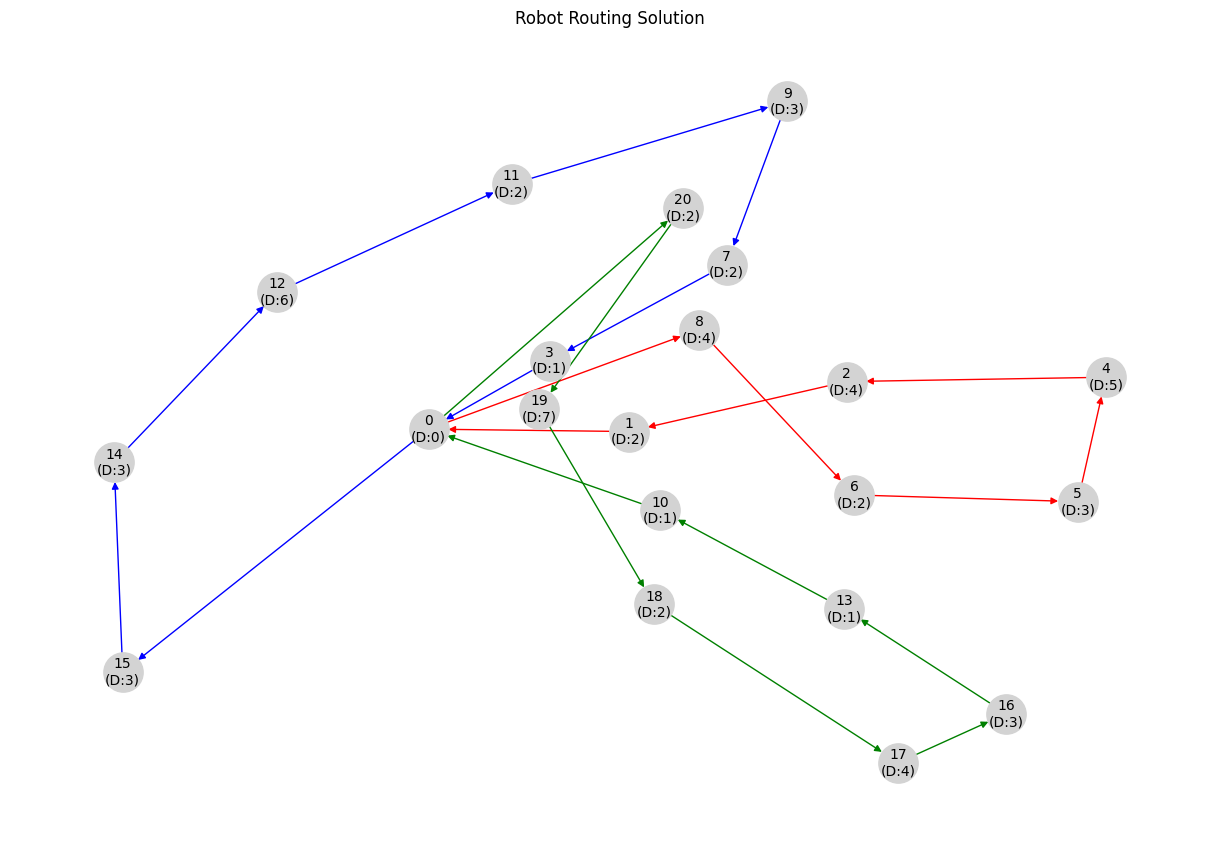

In [73]:
import matplotlib.pyplot as plt
import networkx as nx

# 데이터를 기반으로 생성된 경로 결과를 하드코딩
vehicle_routes = [
    [0, 8, 6, 5, 4, 2, 1, 0],  # 로봇 1
    [0, 15, 14, 12, 11, 9, 7, 3, 0],  # 로봇 2
    [0, 20, 19, 18, 17, 16, 13, 10, 0],  # 로봇 3
]

# 노드별 수요
demands = [0, 2, 4, 1, 5, 3, 2, 2, 4, 3, 1, 2, 6, 1, 3, 3, 3, 4, 2, 7, 2]

# 시각화를 위한 색상 설정
colors = ["red", "blue", "green"]

# 그래프 생성
G = nx.DiGraph()

# 노드 추가 및 라벨링 (수요 포함)
for i, demand in enumerate(demands):
    G.add_node(i, demand=demand)

# 경로 추가 및 색상 부여
for vehicle_id, route in enumerate(vehicle_routes):
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], color=colors[vehicle_id])

# 엣지 색상 추출
edges = G.edges()
edge_colors = [G[u][v]["color"] for u, v in edges]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 그래프 시각화
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    # with_labels=True,
    edge_color=edge_colors,
    node_color="lightgrey",
    node_size=800,
)

# 노드에 수요 정보 추가
demand_labels = {node: f"{node}\n(D:{data['demand']})" for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=demand_labels, font_size=10)

plt.title("Robot Routing Solution")
plt.savefig("image/robot_routing_solution.png")
plt.show()

In [74]:
import folium

# 노드 좌표 데이터 (경위도)
node_coords = {
    0: (37.487399, 126.927095),  # 신림동 주민센터
    1: (37.487397, 126.928485),
    2: (37.486959, 126.927889),
    3: (37.485849, 126.928131),
    4: (37.4863, 126.928085),
    5: (37.486501, 126.928528),
    6: (37.485665, 126.928775),
    7: (37.485027, 126.928041),
    8: (37.4848, 126.92747),
    9: (37.484897, 126.927185),
    10: (37.484975, 126.926831),
    11: (37.485457, 126.927358),
    12: (37.486413, 126.92811),
    13: (37.486137, 126.926612),
    14: (37.486493, 126.926905),
    15: (37.486979, 126.926123),
    16: (37.487433, 126.925733),
    17: (37.486567, 126.925151),
    18: (37.486268, 126.925955),
    19: (37.485901, 126.925445),
    20: (37.485551, 126.925938)
}

# 경로 결과
vehicle_routes = [
    [0, 8, 6, 5, 4, 2, 1],  # 로봇 1
    [0, 15, 14, 12, 11, 9, 7, 3],  # 로봇 2
    [0, 20, 19, 18, 17, 16, 13, 10],  # 로봇 3
]

# 색상 설정
colors = ["red", "blue", "green"]

# 지도 생성 (중심: 행운동 주민센터 좌표)
map_center = node_coords[0]
m = folium.Map(location=map_center, zoom_start=16)

# 노드 색상 매핑
node_colors = ["gray"] * len(node_coords)  # 기본 색상: gray
for vehicle_id, route in enumerate(vehicle_routes):
    for node in route:
        node_colors[node] = colors[vehicle_id]  # 경로에 속한 노드는 해당 경로의 색상

# 노드 표시
for node, coord in node_coords.items():
    folium.Marker(
        location=coord,
        popup=f"Node {node}",
        icon=folium.Icon(color=node_colors[node]),
    ).add_to(m)

# 경로 시각화
for vehicle_id, route in enumerate(vehicle_routes):
    route_coords = [node_coords[node] for node in route]
    folium.PolyLine(
        locations=route_coords,
        color=colors[vehicle_id],
        weight=5,
        opacity=0.7,
        popup=f"Robot {vehicle_id + 1} Route",
    ).add_to(m)

# 결과 지도 저장 또는 표시
m.save("visualization/route_visualization_robot.html")
m

## react 시각화

### 기본 함수 불러오기

In [75]:
# 라이브러리 불러오기
import numpy as np
import itertools
import requests
import polyline
import json
import os
import math

import random as rd
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

In [76]:
# 좌표 거리 생성 함수
## 직선 거리 계산 함수
## 거리 계산할 때 경로를 모르는 경우 사용
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    '''
    좌표 거리 생성 함수 
    - 직선 거리 계산 
    - 경로를 모르는 경우 두 지점 간의 대략적인 직선 거리를 계산할 때 사용

    입력값:
        lat1: 출발지 위도 (float)
        lon1: 출발지 경도 (float)
        lat2: 도착지 위도 (float)
        lon2: 도착지 경도 (float)

    출력값:
        두 지점 간의 직선 거리 (킬로미터 단위, float)
    '''
# 직선 거리 계산
# 입력값: 출발지 위도, 경도 / 도착지 위도, 경도
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 # 도착지 위도 - 출발지 위도
    dlon = lon2 - lon1 # 도착지 경도 - 출발지 경도

    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (킬로미터 단위)
    km = km_constant * c
    
    return km # 출발지-도착지 사이의 직선 거리 반환

In [77]:
# trips 데이터 생성 함수
#### osrm 페키지로 경로 추출
# 입력으로 받은 출발지와 목적지 좌표를 이용하여 경로 정보를 가져오는 함수
def get_res(point, mode = 'foot'): # 도보 이용

   # point: 출발지와 목적지 좌표 정보를 포함하는 리스트[lat1, lon1, lat2, lon2]
   # mode: 이동 수단 (기본값: 도보)

   status = 'defined'

   # 요청을 재시도할 수 있도록 세션 객체 생성 및 설정
   session = requests.Session()
   retry = Retry(connect=3, backoff_factor=0.5)
   adapter = HTTPAdapter(max_retries=retry)
   session.mount('http://', adapter)
   session.mount('https://', adapter)

   #### url 생성 코드
   # 전체 경로 정보를 요청
   overview = '?overview=full'
   # lon, lat, lon, lat 형식의 출발지 목적지 좌표
   loc = f"{point[0]},{point[1]};{point[2]},{point[3]}"
   # 보행경로 url
   url = f'http://router.project-osrm.org/route/v1/{mode}/'
   # 경로 정보 요청
   r = session.get(url + loc + overview) 
   
   # 만약 경로가 안뜰 때 대체 결과 생성
   ## 직선 거리 구하기
   if r.status_code!= 200:
      
      status = 'undefined'
      
       # 직선 거리 계산
      distance = calculate_straight_distance(point[1], point[0], point[3], point[2]) * 1000 
      # m단위 
      
      # 경로 정보 생성 (출발지와 목적지 좌표만 포함)
      route = [[point[0], point[1]], [point[2], point[3]]]

      # 소요 시간 및 타임스탬프 계산 (가정: 보행 속도 10km/h)
      speed_km = 30#km
      speed = (speed_km * 1000/60)      
      duration = distance/speed * 60 # 초단위
      
      timestamp = [0, duration]

      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
   
      return result, status
   
   # 경로 정보를 성공적으로 가져온 경우, JSON 응답을 반환
   res = r.json()   
   return res, status

In [78]:
# 경로를 가는데 걸리는 시간과 거리 추출 함수
def extract_duration_distance(res, speed_kmh):
   # get_res함수에서 추출된 데이터에서 시간과 거리 뽑기
   # 입력값: res(get_res함수에서 추출된 데이터), 속도 (km/h)
   
   distance = res['routes'][0]['distance']
   # JSON 응답에서 첫 번째 경로의 거리 값을 추출
   # m 단위로 거리 추출
   # duration = res['routes'][0]['duration']/(60)  # 분 단위로 변환
   
   # 속도로 시간 계산
   speed_kmh = speed_kmh  # km/h
   speed_mps = speed_kmh * 1000 / 3600  # 속도를 m/s로 변환
   duration = distance / speed_mps # 초 단위
   
   return duration, distance # 소요 시간, 거리 반환

# 경로 추출 함수
def extract_route(res):
    # 입력값: res(get_res함수에서 추출된 데이터)
   
    # get_res함수에서 추출된 데이터에서 경로 뽑기
    # 경로가 인코딩 되어 있기 때문에 아래 함수를 써서 디코딩해주어야지 위경도로 이루어진 경로가 나옴
    route = polyline.decode(res['routes'][0]['geometry'])
    
    # 사용할 형식에 맞춰 위경도 좌표의 위치를 바꿔주는 것
    route = list(map(lambda data: [data[1],data[0]] ,route))
    # data: [위도, 경도] 형식의 좌표 쌍 -> [경도, 위도] 형식의 좌표 쌍

    return route # [[127.0, 37.0], [127.1, 37.1], ...] 형식의 경로 반환

In [79]:
# 총 걸리는 시간을 경로의 거리 기준으로 쪼개주는 함수
def extract_timestamp(route, duration):
    '''
    경로의 각 구간 거리 비율에 따라 예상 도착 시간을 계산하는 함수

    입력값:
        route: 경로 정보 (위도와 경도로 구성된 리스트)
        duration: 총 소요 시간 (분 단위, float)
    
    출력값:
        timestamp: 각 지점의 예상 도착 시간 리스트 (분 단위)
    '''
    # 입력값: route(경로 정보), duration(총 소요 시간)
    
    # 리스트를 numpy이 배열로 변경
    rt = np.array(route)
    # 리스트를 수평 기준으로 합치기
    rt = np.hstack([rt[:-1,:], rt[1:,:]])
    # [출발점_lat, 출발점_lon, 도착점_lat, 도착점_lon] 형식으로 변환

    # 각각 직선거리 추출(리스트 형태)
    per = calculate_straight_distance(rt[:,1], rt[:,0], rt[:,3], rt[:,2])
    # 출발점 경도, 출발점 위도, 도착점 경도, 도착점 위도를 이용하여 직선거리 계산

    # 각각의 직선거리를 전체 직선거리의 합으로 나누기
    per = per / np.sum(per)
    # 각 구간의 직선 거리 비율 계산
    # 전체 경로에서 해당 구간이 차지하는 비율 계산

    # 계산된 비율을 기반으로 각 지점 도착 예상 시간 계산
    timestamp = per * duration
    ## 각 구간의 비율에 전체 소요 시간을 곱해 각 구간의 소요 시간 계산
    
    # 각 구간의 소요 시간을 누적하여 더하기
    timestamp = np.hstack([np.array([0]),timestamp])

    # 타임스탬프 배열의 누적 합을 계산하여 각 지점의 예상 도착 시간을 생성
    timestamp = list(itertools.accumulate(timestamp)) 
    # 소수점 둘째 자리까지 반올림
    timestamp = [round(t, 2) for t in timestamp]
    
    return timestamp # 각 지점의 예상 도착 시간 리스트 e.g. [0, 10, 20, 30, ...] 반환

In [80]:
from functools import partial

# 모든 함수를 한번에 실행하는 코드(trips 데이터의 형태로 저장)
def osrm_routing_machine(O, D, mode, speed_kmh):
   # 입력값: 출발지 좌표, 목적지 좌표, 이동 수단, 속도

   # osrm 데이터 생성
   osrm_base, status = get_res([O.x, O.y, D.x, D.y], mode)
   
   # osrm 데이터가 생성 됬으면 진행
   if status == 'defined':
      # 거리 및 걸리는 시간 추출
      duration, distance = extract_duration_distance(osrm_base, speed_kmh)
      # 경로 추출
      route = extract_route(osrm_base)
      # timestamp 생성
      timestamp = extract_timestamp(route, duration)
      # 결과 저장
      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
      
      return result
   else: 
      return osrm_base # 경로 데이터 없을 때는 직선거리 데이터 반환
   
# OD_data 한쌍일 때 osrm_routing_machine작동함수
def osrm_routing_machine_multiprocess(OD, mode, speed_kmh):
   O, D = OD
   result = osrm_routing_machine(O, D, mode, speed_kmh)
   return result
# OD_data 데이터가 리스트쌍 일때의 osrm_routing_machine 작동함수
def osrm_routing_machine_multiprocess_all(OD_data, mode, speed_kmh):
    results = list(map(partial(osrm_routing_machine_multiprocess, mode = mode, speed_kmh=speed_kmh), OD_data))
    return results

In [81]:
# 출발시간 기반으로 탑승시간 계산 함수
def calculate_boarding_time(start_times):
    '''
    출발시간을 기반으로 탑승 시간을 계산하는 함수
    - 버스는 10분 간격으로 출발한다고 가정

    입력값:
        start_times: 출발 시간 리스트 (분 단위)

    출력값:
        boarding_times: 각 출발 시간에 대응하는 탑승 시간 리스트 (분 단위)
    '''
    boarding_times = []
    for start_time in start_times:
        # 버스는 10분 간격으로 출발한다고 가정
        boarding_time = math.ceil(start_time / (10 * 60)) * (10 * 60)
        boarding_times.append(boarding_time)
    return boarding_times

# 데이터프레임에서 OD 데이터와 출발시간, 탑승시간 데이터 추출 함수
def extract_od_and_start_time(df):
    '''
    데이터프레임에서 OD 데이터와 출발 시간, 탑승 시간 데이터를 추출하는 함수

    입력값:
        df: OD 데이터가 포함된 데이터프레임
            - 컬럼: start_point (출발지 위경도), end_point (도착지 위경도), start_time, boarding_time

    출력값:
        od_data: OD 데이터 리스트 ([[출발지 위경도, 도착지 위경도], ...])
        start_time: 출발 시간 리스트
        boarding_time: 탑승 시간 리스트
    '''
    # OD 데이터를 추출 (출발점과 도착점의 위경도)
    od_data = [[row['start_point'], row['end_point']] for _, row in df.iterrows()]
    
    # 출발시간과 탑승시간 데이터를 리스트로 추출
    start_time = [time for time in df['start_time'].tolist()]  # 분 -> 초 변환
    boarding_time = [time for time in df['boarding_time'].tolist()]  # 분 -> 초 변환

    
    return od_data, start_time, boarding_time

In [82]:
od_data_for_ortools

,point,point_coord,longitude,latitude
0,신림동 주민센터,POINT (126.927095 37.487399),126.927095,37.487399
1,home1,POINT (126.928485 37.487397),126.928485,37.487397
2,home2,POINT (126.927889 37.486959),126.927889,37.486959
3,home3,POINT (126.928131 37.485849),126.928131,37.485849
4,home4,POINT (126.928085 37.4863),126.928085,37.486300
5,home5,POINT (126.928528 37.486501),126.928528,37.486501
6,home6,POINT (126.928775 37.485665),126.928775,37.485665
7,home7,POINT (126.928041 37.485027),126.928041,37.485027
8,home8,POINT (126.92747 37.4848),126.927470,37.484800
9,home9,POINT (126.927185 37.484897),126.927185,37.484897


In [83]:
# React에 사용할 OD 데이터 생성
point_lookup = od_data_for_ortools.set_index("point")[["longitude", "latitude"]].to_dict("index")

# Generate OD data for each vehicle
robot_path = []
for _, row in route_data_robot.iterrows():
    vehicle = row["Vehicle"]
    route_str = row["Route"]  # 전체 Route 문자열 그대로 저장
    route = list(map(int, row["Route"].split(" -> ")))  # Split route into integers for processing
    origin = route[0]  # 출발지는 route의 첫 번째 값
    destination = route[-2]  # 도착지는 route의 마지막 값 (항상 0)

    # 마지막 -> 0을 제거한 route 문자열 생성
    if route_str.endswith(" -> 0"):
        route_str = route_str[:-5]  # " -> 0" 문자열 제거

    robot_path.append({
        # "Vehicle": vehicle,
        "O_point": od_data_for_ortools.loc[origin, "point"],
        "O_coord": [od_data_for_ortools.loc[origin, "longitude"], od_data_for_ortools.loc[origin, "latitude"]],
        "D_point": od_data_for_ortools.loc[destination, "point"],
        "D_coord": [od_data_for_ortools.loc[destination, "longitude"], od_data_for_ortools.loc[destination, "latitude"]],
        "route": route_str  # 마지막 -> 0 제거된 Route 문자열
    })

od_data_for_react = pd.DataFrame(robot_path)

In [84]:
od_data_for_react

,O_point,O_coord,D_point,D_coord,route
0,신림동 주민센터,"[126.927095, 37.487399]",home1,"[126.928485, 37.487397]",0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1
1,신림동 주민센터,"[126.927095, 37.487399]",home3,"[126.928131, 37.485849]",0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3
2,신림동 주민센터,"[126.927095, 37.487399]",home10,"[126.926831, 37.484975]",0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10


In [85]:
# Route를 좌표로 변환하는 함수(geometry)
def get_coordinates_from_route(route, coord_data):
    """
    Given a route in the format "0 -> 8 -> 7 -> ..." and a dataset mapping points to coordinates,
    extract the coordinates in the sequence of the route.
    """
    points = route.replace(" ", "").split("->")
    coordinates = [
        coord_data.loc[int(point), ["longitude", "latitude"]].tolist()
        for point in points
    ]
    return coordinates

# Extract routes with coordinates
od_data_for_react["geometry"] = od_data_for_react["route"].apply(
    lambda r: get_coordinates_from_route(r, od_data_for_ortools)
)

In [86]:
od_data_for_react.to_csv("data/OD_data_robot_with_path.csv")

In [87]:
from shapely.geometry import Point

od_data_for_react["start_time"] = [0] * 3
od_data_for_react["boarding_time"] = [0] * 3

# POINT 객체로 변환
# start_point와 end_point를 POINT 객체로 변환
od_data_for_react['O_coord'] = od_data_for_react['O_coord'].apply(lambda x: Point(x))
od_data_for_react['D_coord'] = od_data_for_react['D_coord'].apply(lambda x: Point(x))

# 열 이름 변경
od_data_for_react.rename(columns={"start_point": "start_station", "O_coord": "start_point", "end_point": "end_station", "D_coord": "end_point"}, inplace=True)

In [88]:
od_data_for_react

,O_point,start_point,D_point,end_point,route,geometry,start_time,boarding_time
0,신림동 주민센터,POINT (126.927095 37.487399),home1,POINT (126.928485 37.487397),0 -> 8 -> 6 -> 5 -> 4 -> 2 -> 1,"[[126.927095, 37.487399], [126.92747, 37.4848]...",0,0
1,신림동 주민센터,POINT (126.927095 37.487399),home3,POINT (126.928131 37.485849),0 -> 15 -> 14 -> 12 -> 11 -> 9 -> 7 -> 3,"[[126.927095, 37.487399], [126.926123, 37.4869...",0,0
2,신림동 주민센터,POINT (126.927095 37.487399),home10,POINT (126.926831 37.484975),0 -> 20 -> 19 -> 18 -> 17 -> 16 -> 13 -> 10,"[[126.927095, 37.487399], [126.925938, 37.4855...",0,0


In [89]:
import requests
import polyline

def calculate_route_with_timestamps(osrm_base_url, geometry, start_time, speed=5.76):
    '''
    OSRM을 이용하여 경로를 계산하고 입력 속도를 기반으로 타임스탬프를 생성합니다.

    Args:
        osrm_base_url (str): OSRM 서버의 기본 URL
        geometry (list): 경유 좌표 리스트
        start_time (int): 경로 시작 시간 (초 단위)
        speed (float): 차량 속도 (km/h)
    
    Returns:
        dict: React에서 사용할 결과 형식
    '''
    # Convert speed from km/h to m/s
    speed_m_s = speed / 3.6

    # Convert geometry coordinates to OSRM request format
    coords = ';'.join([f"{lon},{lat}" for lon, lat in geometry])

    # OSRM 요청 URL 생성
    route_url = f"{osrm_base_url}/route/v1/driving/{coords}?overview=full&geometries=polyline&steps=false"

    # OSRM 요청
    response = requests.get(route_url)
    if response.status_code != 200:
        raise Exception(f"OSRM 요청 실패: {response.status_code} - {response.text}")

    data = response.json()
    if not data.get("routes"):
        raise Exception("OSRM 결과에서 경로를 찾을 수 없습니다.")

    # 결과 처리
    route_geometry = [(lon, lat) for lat, lon in polyline.decode(data["routes"][0]["geometry"])]
    total_distance_m = data["routes"][0]["distance"]  # 전체 거리 (m)

    # 거리와 속도를 기반으로 타임스탬프 계산
    timestamps = [start_time]  # 첫 번째 좌표에서 시작
    cumulative_time = 0  # 시작 시간은 0

    distances = [0] + [
        total_distance_m * i / (len(route_geometry) - 1) for i in range(1, len(route_geometry))
    ]

    for i in range(len(distances) - 1):
        segment_distance = distances[i + 1] - distances[i]
        cumulative_time += segment_distance / speed_m_s  # 고정 속도로 시간 계산
        timestamps.append(start_time + cumulative_time)

    # 결과 저장
    result = {
        "route": route_geometry,
        "timestamp": timestamps,
        "duration": cumulative_time,  # 계산된 총 소요 시간
        "distance": total_distance_m,  # 전체 거리
    }
    return result

# OSRM 기본 URL
osrm_base_url = "http://router.project-osrm.org"

# 데이터프레임 처리
results = []

for index, row in od_data_for_react.iterrows():
    result = calculate_route_with_timestamps(
        osrm_base_url=osrm_base_url,
        geometry=row['geometry'],
        start_time=row['start_time'],
        speed=5.76
    )
    results.append(result)

# 결과를 데이터프레임에 추가
result_robot = results

In [90]:
result_robot

[{'route': [(126.92715, 37.48725),
   (126.92709, 37.48724),
   (126.92722, 37.48676),
   (126.92735, 37.48633),
   (126.92748, 37.48587),
   (126.92751, 37.48576),
   (126.92763, 37.48535),
   (126.92765, 37.4853),
   (126.92734, 37.48525),
   (126.92744, 37.48486),
   (126.92745, 37.48486),
   (126.92758, 37.48489),
   (126.92776, 37.48492),
   (126.92798, 37.48496),
   (126.92833, 37.48502),
   (126.92866, 37.48509),
   (126.92903, 37.48516),
   (126.92882, 37.48568),
   (126.9288, 37.48573),
   (126.92867, 37.4861),
   (126.92856, 37.48635),
   (126.92849, 37.48649),
   (126.92843, 37.4866),
   (126.92811, 37.48648),
   (126.92818, 37.48633),
   (126.92822, 37.48625),
   (126.92856, 37.48635),
   (126.92843, 37.4866),
   (126.92822, 37.48705),
   (126.92805, 37.48743),
   (126.92846, 37.4875)],
  'timestamp': [0,
   18.05,
   36.1,
   54.150000000000006,
   72.2,
   90.25000000000001,
   108.30000000000001,
   126.35000000000001,
   144.4,
   162.45,
   180.50000000000003,
   198.5

### 트럭이 주민센터로 도착하는 시간에 맞춰 로못의 출발시간 timstamp 조정하기

In [91]:
# 은주가 만든 sub-주민센터 json 파일 불러오기
with open("react_robot/trips_robot_sub.json", "r") as f:
    result_sub = json.load(f)

In [92]:
result_sub_df = pd.DataFrame(result_sub)
result_sub_df

,route,timestamp,duration,distance
0,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[594.0, 594.0411279683725, 594.0440030023555, ...",3.44526,5742.1
1,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[573.0, 573.0411279683725, 573.0440030023555, ...",3.44526,5742.1
2,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[540.0, 540.0411279683725, 540.0440030023555, ...",3.44526,5742.1
3,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[556.0, 556.0411279683725, 556.0440030023555, ...",3.44526,5742.1
4,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[566.0, 566.0047991191735, 566.0873228125947, ...",14.48946,24149.1
5,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[565.0, 565.0047991191735, 565.0873228125947, ...",14.48946,24149.1
6,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[569.0, 569.1465917466738, 569.2154001285417, ...",9.55158,15919.3
7,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[566.0, 566.1465917466738, 566.2154001285417, ...",9.55158,15919.3
8,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[568.0, 568.1465917466738, 568.2154001285417, ...",9.55158,15919.3
9,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[568.0, 568.1465917466738, 568.2154001285417, ...",9.55158,15919.3


In [93]:
modified_result_sub_df = result_sub_df.copy()
# route의 첫 번째 좌표와 마지막 좌표를 POINT 객체로 변환하여 start_point와 end_point 컬럼 추가
modified_result_sub_df['start_point'] = modified_result_sub_df['route'].apply(lambda x: Point(x[0]))
modified_result_sub_df['end_point'] = modified_result_sub_df['route'].apply(lambda x: Point(x[-1]))
modified_result_sub_df['start_time'] = 0
modified_result_sub_df['boarding_time'] = 0

In [94]:
modified_result_sub_df

,route,timestamp,duration,distance,start_point,end_point,start_time,boarding_time
0,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[594.0, 594.0411279683725, 594.0440030023555, ...",3.44526,5742.1,POINT (126.87825 37.48183),POINT (126.92715 37.48725),0,0
1,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[573.0, 573.0411279683725, 573.0440030023555, ...",3.44526,5742.1,POINT (126.87825 37.48183),POINT (126.92715 37.48725),0,0
2,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[540.0, 540.0411279683725, 540.0440030023555, ...",3.44526,5742.1,POINT (126.87825 37.48183),POINT (126.92715 37.48725),0,0
3,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[556.0, 556.0411279683725, 556.0440030023555, ...",3.44526,5742.1,POINT (126.87825 37.48183),POINT (126.92715 37.48725),0,0
4,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[566.0, 566.0047991191735, 566.0873228125947, ...",14.48946,24149.1,POINT (126.7658 37.64927),POINT (126.94701 37.59956),0,0
5,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[565.0, 565.0047991191735, 565.0873228125947, ...",14.48946,24149.1,POINT (126.7658 37.64927),POINT (126.94701 37.59956),0,0
6,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[569.0, 569.1465917466738, 569.2154001285417, ...",9.55158,15919.3,POINT (127.14656 37.58248),POINT (127.03635 37.55952),0,0
7,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[566.0, 566.1465917466738, 566.2154001285417, ...",9.55158,15919.3,POINT (127.14656 37.58248),POINT (127.03635 37.55952),0,0
8,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[568.0, 568.1465917466738, 568.2154001285417, ...",9.55158,15919.3,POINT (127.14656 37.58248),POINT (127.03635 37.55952),0,0
9,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[568.0, 568.1465917466738, 568.2154001285417, ...",9.55158,15919.3,POINT (127.14656 37.58248),POINT (127.03635 37.55952),0,0


In [95]:
OD_data_truck_sub, start_time_sub, boarding_time_sub = extract_od_and_start_time(modified_result_sub_df)

In [96]:
OD_data_truck_sub

[[<POINT (126.878 37.482)>, <POINT (126.927 37.487)>],
 [<POINT (126.878 37.482)>, <POINT (126.927 37.487)>],
 [<POINT (126.878 37.482)>, <POINT (126.927 37.487)>],
 [<POINT (126.878 37.482)>, <POINT (126.927 37.487)>],
 [<POINT (126.766 37.649)>, <POINT (126.947 37.6)>],
 [<POINT (126.766 37.649)>, <POINT (126.947 37.6)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.036 37.56)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37.582)>, <POINT (127.022 37.555)>],
 [<POINT (127.147 37

In [97]:
# 트럭 이용 시 시간 계산
result_truck_sub = osrm_routing_machine_multiprocess_all(OD_data_truck_sub, 'car', 100)

In [98]:
result_truck_sub

[{'route': [[126.87825, 37.48183],
   [126.87851, 37.48125],
   [126.87853, 37.48121],
   [126.87881, 37.48053],
   [126.87887, 37.48038],
   [126.87893, 37.48026],
   [126.87924, 37.47955],
   [126.8793, 37.4794],
   [126.87935, 37.47928],
   [126.87962, 37.47867],
   [126.88078, 37.47601],
   [126.88085, 37.47585],
   [126.88104, 37.4759],
   [126.88149, 37.47602],
   [126.88174, 37.47609],
   [126.88194, 37.47615],
   [126.8848, 37.47697],
   [126.88712, 37.47764],
   [126.88753, 37.47777],
   [126.88805, 37.47793],
   [126.88893, 37.47863],
   [126.88939, 37.47901],
   [126.88983, 37.47935],
   [126.89179, 37.47899],
   [126.89308, 37.47876],
   [126.89475, 37.47846],
   [126.895, 37.47843],
   [126.89531, 37.47841],
   [126.8955, 37.47841],
   [126.8956, 37.4784],
   [126.89581, 37.47841],
   [126.8961, 37.47844],
   [126.8965, 37.47851],
   [126.89848, 37.47882],
   [126.89959, 37.47902],
   [126.90088, 37.47925],
   [126.90186, 37.47943],
   [126.90249, 37.47955],
   [126.90393,

In [99]:
result_truck_sub_df = pd.DataFrame(result_truck_sub)
result_truck_sub_df

,route,timestamp,duration,distance
0,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[0.0, 2.47, 2.64, 5.51, 6.14, 6.66, 9.67, 10.3...",206.7120,5742.0
1,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[0.0, 2.47, 2.64, 5.51, 6.14, 6.66, 9.67, 10.3...",206.7120,5742.0
2,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[0.0, 2.47, 2.64, 5.51, 6.14, 6.66, 9.67, 10.3...",206.7120,5742.0
3,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[0.0, 2.47, 2.64, 5.51, 6.14, 6.66, 9.67, 10.3...",206.7120,5742.0
4,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[0.0, 0.29, 5.24, 12.15, 16.19, 17.8, 18.34, 2...",869.3460,24148.5
5,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[0.0, 0.29, 5.24, 12.15, 16.19, 17.8, 18.34, 2...",869.3460,24148.5
6,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[0.0, 8.8, 12.92, 18.08, 20.19, 20.8, 21.25, 2...",573.0912,15919.2
7,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[0.0, 8.8, 12.92, 18.08, 20.19, 20.8, 21.25, 2...",573.0912,15919.2
8,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[0.0, 8.8, 12.92, 18.08, 20.19, 20.8, 21.25, 2...",573.0912,15919.2
9,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[0.0, 8.8, 12.92, 18.08, 20.19, 20.8, 21.25, 2...",573.0912,15919.2


In [100]:
# 출발 시간 랜덤 지점하기
import random

# 랜덤 시드 고정
random.seed(42)

# 각 리스트에 대해 0~50 사이의 랜덤 값을 생성하고, 리스트 값에 더하기
adjusted_timestamp = []
for ts_list in result_truck_sub_df["timestamp"]:
    random_offset = random.randint(0, 50)  # 0~50 사이의 랜덤 값 생성
    adjusted_timestamp.append([ts + random_offset for ts in ts_list])  # 리스트 내 값 모두 더하기

# 결과 반영
result_truck_sub_df["timestamp"] = adjusted_timestamp

# 결과 출력
result_truck_sub_df

,route,timestamp,duration,distance
0,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[26.0, 28.47, 28.64, 31.509999999999998, 32.14...",206.7120,5742.0
1,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[48.0, 50.47, 50.64, 53.51, 54.14, 54.66, 57.6...",206.7120,5742.0
2,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[33.0, 35.47, 35.64, 38.51, 39.14, 39.66, 42.6...",206.7120,5742.0
3,"[[126.87825, 37.48183], [126.87851, 37.48125],...","[28.0, 30.47, 30.64, 33.51, 34.14, 34.66, 37.6...",206.7120,5742.0
4,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[2.0, 2.29, 7.24, 14.15, 18.19, 19.8, 20.34, 2...",869.3460,24148.5
5,"[[126.7658, 37.64927], [126.76575, 37.64921], ...","[45.0, 45.29, 50.24, 57.15, 61.19, 62.8, 63.34...",869.3460,24148.5
6,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[19.0, 27.8, 31.92, 37.08, 39.19, 39.8, 40.25,...",573.0912,15919.2
7,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[34.0, 42.8, 46.92, 52.08, 54.19, 54.8, 55.25,...",573.0912,15919.2
8,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[3.0, 11.8, 15.92, 21.08, 23.19, 23.8, 24.25, ...",573.0912,15919.2
9,"[[127.14656, 37.58248], [127.14613, 37.58031],...","[28.0, 36.8, 40.92, 46.08, 48.19, 48.8, 49.25,...",573.0912,15919.2


In [101]:
# 딕셔너리 리스트로 변환

# 데이터프레임 변환
updated_result_truck_sub = []
for idx, row in result_truck_sub_df.iterrows():
    # 좌표 변환: [경도, 위도] -> (경도, 위도)
    transformed_route = [(coord[0], coord[1]) for coord in row["route"]]

    # 데이터 추가
    updated_result_truck_sub.append({
        "route": transformed_route,
        "timestamp": row["timestamp"],
        "duration": row["duration"],
        "distance": row["distance"]
    })

# 출력 결과
updated_result_truck_sub

[{'route': [(126.87825, 37.48183),
   (126.87851, 37.48125),
   (126.87853, 37.48121),
   (126.87881, 37.48053),
   (126.87887, 37.48038),
   (126.87893, 37.48026),
   (126.87924, 37.47955),
   (126.8793, 37.4794),
   (126.87935, 37.47928),
   (126.87962, 37.47867),
   (126.88078, 37.47601),
   (126.88085, 37.47585),
   (126.88104, 37.4759),
   (126.88149, 37.47602),
   (126.88174, 37.47609),
   (126.88194, 37.47615),
   (126.8848, 37.47697),
   (126.88712, 37.47764),
   (126.88753, 37.47777),
   (126.88805, 37.47793),
   (126.88893, 37.47863),
   (126.88939, 37.47901),
   (126.88983, 37.47935),
   (126.89179, 37.47899),
   (126.89308, 37.47876),
   (126.89475, 37.47846),
   (126.895, 37.47843),
   (126.89531, 37.47841),
   (126.8955, 37.47841),
   (126.8956, 37.4784),
   (126.89581, 37.47841),
   (126.8961, 37.47844),
   (126.8965, 37.47851),
   (126.89848, 37.47882),
   (126.89959, 37.47902),
   (126.90088, 37.47925),
   (126.90186, 37.47943),
   (126.90249, 37.47955),
   (126.90393,

In [102]:
# 모든 행의 route의 마지막 값 추출
last_points = result_truck_sub_df['route'].apply(lambda r: r[-1])

# 결과 출력
print(last_points.tolist())

[[126.92715, 37.48725], [126.92715, 37.48725], [126.92715, 37.48725], [126.92715, 37.48725], [126.94701, 37.59956], [126.94701, 37.59956], [127.03635, 37.55952], [127.03635, 37.55952], [127.03635, 37.55952], [127.03635, 37.55952], [127.03635, 37.55952], [127.03635, 37.55952], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553], [127.02213, 37.5553]]


In [103]:
# 신림동까지 가는 경로 중 가장 늦게 도착하는 시간을 찾기
# 도착지가 [126.92715, 37.48725]인 행의 마지막 timestamp 값 추출
destination = [126.92715, 37.48725] # 주민센터 앞 거리 값
last_timestamps = result_truck_sub_df[result_truck_sub_df['route'].apply(lambda r: r[-1] == destination)]['timestamp'].apply(lambda ts: ts[-1])
# 결과 출력
print(last_timestamps.tolist())

[232.71, 254.71, 239.71, 234.71]


In [104]:
# 트럭이 동사무소로 도착하는 시간에 맞춰 로봇의 출발 시간을 조정
# 타임스탬프의 시작 시간을 600으로 변경하는 함수
def adjust_timestamps(data_list):
    for entry in data_list:
        timestamps = entry['timestamp']
        offset = 285.71000 - timestamps[0]  # 시작 시간을 600으로 변경하기 위한 오프셋 계산
        entry['timestamp'] = [t + offset for t in timestamps]
    return data_list


# 타임스탬프 업데이트
updated_result_robot = adjust_timestamps(result_robot)

In [105]:
updated_result_robot_df = pd.DataFrame(updated_result_robot)
updated_result_robot_df

,route,timestamp,duration,distance
0,"[(126.92715, 37.48725), (126.92709, 37.48724),...","[285.71, 303.76, 321.81, 339.86, 357.909999999...",541.5000,866.4
1,"[(126.92715, 37.48725), (126.92709, 37.48724),...","[285.71, 299.475625, 313.24125, 327.006875, 34...",660.7500,1057.2
2,"[(126.92715, 37.48725), (126.92709, 37.48724),...","[285.71, 305.2829166666518, 324.85583333330356...",822.0625,1315.3


In [106]:
updated_result_robot

[{'route': [(126.92715, 37.48725),
   (126.92709, 37.48724),
   (126.92722, 37.48676),
   (126.92735, 37.48633),
   (126.92748, 37.48587),
   (126.92751, 37.48576),
   (126.92763, 37.48535),
   (126.92765, 37.4853),
   (126.92734, 37.48525),
   (126.92744, 37.48486),
   (126.92745, 37.48486),
   (126.92758, 37.48489),
   (126.92776, 37.48492),
   (126.92798, 37.48496),
   (126.92833, 37.48502),
   (126.92866, 37.48509),
   (126.92903, 37.48516),
   (126.92882, 37.48568),
   (126.9288, 37.48573),
   (126.92867, 37.4861),
   (126.92856, 37.48635),
   (126.92849, 37.48649),
   (126.92843, 37.4866),
   (126.92811, 37.48648),
   (126.92818, 37.48633),
   (126.92822, 37.48625),
   (126.92856, 37.48635),
   (126.92843, 37.4866),
   (126.92822, 37.48705),
   (126.92805, 37.48743),
   (126.92846, 37.4875)],
  'timestamp': [285.71,
   303.76,
   321.81,
   339.86,
   357.90999999999997,
   375.96,
   394.01,
   412.06,
   430.11,
   448.15999999999997,
   466.21000000000004,
   484.26,
   502.31

## scatter plot & index 

In [107]:
# stops_point 데이터를 딕셔너리 형식으로 변환
stops_point = {
    "관악1sub터미널": [126.87877, 37.481974],
    "서대문구sub터미널": [126.7653867, 37.6495], 
    "성동구sub터미널": [127.1473857, 37.5823781],
    "신림동 주민센터": [126.927095, 37.487399],
    "홍은동 주민센터": [126.946994, 37.599580],
    "행당동 주민센터": [127.036352, 37.559477],
    "금호동 주민센터": [127.021602, 37.555372], 
    "home1": [126.928485, 37.487397],
    "home2": [126.927889, 37.486959],
    "home3": [126.928131, 37.485849],
    "home4": [126.928085, 37.486300],
    "home5": [126.928528, 37.486501],
    "home6": [126.928775, 37.485665],
    "home7": [126.928041, 37.485027],
    "home8": [126.927470, 37.484800],
    "home9": [126.927185, 37.484897],
    "home10": [126.926831, 37.484975],
    "home11": [126.927358, 37.485457],
    "home12": [126.928110, 37.486413],
    "home13": [126.926612, 37.486137],
    "home14": [126.926905, 37.486493],
    "home15": [126.926123, 37.486979],
    "home16": [126.925733, 37.487433],
    "home17": [126.925151, 37.486567],
    "home18": [126.925955, 37.486268],
    "home19": [126.925445, 37.485901],
    "home20": [126.925938, 37.485551]
}

In [108]:
# icon data 설정
icon_data = [{"name": point, "coordinates": point_coord} for point, point_coord in stops_point.items()]
icon_data

[{'name': '관악1sub터미널', 'coordinates': [126.87877, 37.481974]},
 {'name': '서대문구sub터미널', 'coordinates': [126.7653867, 37.6495]},
 {'name': '성동구sub터미널', 'coordinates': [127.1473857, 37.5823781]},
 {'name': '신림동 주민센터', 'coordinates': [126.927095, 37.487399]},
 {'name': '홍은동 주민센터', 'coordinates': [126.946994, 37.59958]},
 {'name': '행당동 주민센터', 'coordinates': [127.036352, 37.559477]},
 {'name': '금호동 주민센터', 'coordinates': [127.021602, 37.555372]},
 {'name': 'home1', 'coordinates': [126.928485, 37.487397]},
 {'name': 'home2', 'coordinates': [126.927889, 37.486959]},
 {'name': 'home3', 'coordinates': [126.928131, 37.485849]},
 {'name': 'home4', 'coordinates': [126.928085, 37.4863]},
 {'name': 'home5', 'coordinates': [126.928528, 37.486501]},
 {'name': 'home6', 'coordinates': [126.928775, 37.485665]},
 {'name': 'home7', 'coordinates': [126.928041, 37.485027]},
 {'name': 'home8', 'coordinates': [126.92747, 37.4848]},
 {'name': 'home9', 'coordinates': [126.927185, 37.484897]},
 {'name': 'home10', '

In [109]:
# 데이터 저장
path = 'react_robot/public/data/'

with open(os.path.join(path + 'trips_foot.json'), 'w', encoding='utf-8') as file:
    json.dump(updated_result_truck_sub, file)
with open(os.path.join(path + 'trips_car.json'), 'w', encoding='utf-8') as file:
    json.dump(updated_result_robot, file)
with open(os.path.join(path + 'icon_data.json'), 'w', encoding='utf-8') as file:
    json.dump(icon_data, file)
    
# with open(os.path.join(path + 'trips_car_point.json'), 'w', encoding='utf-8') as file:
#     json.dump(scatterplot_data, file)

In [110]:
final_result_robot = updated_result_truck_sub + updated_result_robot
final_result_robot_df = pd.DataFrame(final_result_robot)

In [111]:
final_result_robot_df

,route,timestamp,duration,distance
0,"[(126.87825, 37.48183), (126.87851, 37.48125),...","[26.0, 28.47, 28.64, 31.509999999999998, 32.14...",206.7120,5742.0
1,"[(126.87825, 37.48183), (126.87851, 37.48125),...","[48.0, 50.47, 50.64, 53.51, 54.14, 54.66, 57.6...",206.7120,5742.0
2,"[(126.87825, 37.48183), (126.87851, 37.48125),...","[33.0, 35.47, 35.64, 38.51, 39.14, 39.66, 42.6...",206.7120,5742.0
3,"[(126.87825, 37.48183), (126.87851, 37.48125),...","[28.0, 30.47, 30.64, 33.51, 34.14, 34.66, 37.6...",206.7120,5742.0
4,"[(126.7658, 37.64927), (126.76575, 37.64921), ...","[2.0, 2.29, 7.24, 14.15, 18.19, 19.8, 20.34, 2...",869.3460,24148.5
5,"[(126.7658, 37.64927), (126.76575, 37.64921), ...","[45.0, 45.29, 50.24, 57.15, 61.19, 62.8, 63.34...",869.3460,24148.5
6,"[(127.14656, 37.58248), (127.14613, 37.58031),...","[19.0, 27.8, 31.92, 37.08, 39.19, 39.8, 40.25,...",573.0912,15919.2
7,"[(127.14656, 37.58248), (127.14613, 37.58031),...","[34.0, 42.8, 46.92, 52.08, 54.19, 54.8, 55.25,...",573.0912,15919.2
8,"[(127.14656, 37.58248), (127.14613, 37.58031),...","[3.0, 11.8, 15.92, 21.08, 23.19, 23.8, 24.25, ...",573.0912,15919.2
9,"[(127.14656, 37.58248), (127.14613, 37.58031),...","[28.0, 36.8, 40.92, 46.08, 48.19, 48.8, 49.25,...",573.0912,15919.2


In [112]:
# 가장 마지막 행의 가장 마지막 timestamp 값 가져오기
robot_last_timestamp1 = final_result_robot_df.iloc[-1]['timestamp'][-1]
robot_last_timestamp2 = final_result_robot_df.iloc[-2]['timestamp'][-1]
robot_last_timestamp3 = final_result_robot_df.iloc[-3]['timestamp'][-1]
print(f"Robot route's last timestamp1: {robot_last_timestamp1}")
print(f"Robot route's last timestamp2: {robot_last_timestamp2}")
print(f"Robot route's last timestamp3: {robot_last_timestamp3}")

# # distance 열 값 모두 더하기 - 의미 없음
# robot_total_distance = final_result_robot_df['distance'].sum()
# print(f"Total Distance: {robot_total_distance}")

Robot route's last timestamp1: 1107.772499999375
Robot route's last timestamp2: 946.4600000000005
Robot route's last timestamp3: 827.21


In [113]:
import folium

def visualize_route_with_lines(df, start_points, middle_points, stop_points):
    """
    데이터프레임의 경로 데이터를 folium으로 시각화하고 경로를 선으로 표현하는 함수.

    Args:
        df (DataFrame): 경로 데이터가 포함된 데이터프레임
        start_points (list): 시작 지점 리스트 (딕셔너리 형태로 'name', 'coordinates' 포함)
        middle_points (list): 중간 지점 리스트 (딕셔너리 형태로 'name', 'coordinates' 포함)
        stop_points (dict): 정류장 딕셔너리 ('name': [longitude, latitude] 형태)
    """
    # 지도 초기화 (첫 번째 시작 지점을 중심으로 설정)
    first_start = start_points[0]['coordinates']
    m = folium.Map(location=[first_start[1], first_start[0]], zoom_start=12)

    # 데이터프레임의 각 경로를 지도에 추가
    for idx, row in df.iterrows():
        route = row["route"]  # 경로 데이터 (좌표 리스트)
        route_latlon = [[coord[1], coord[0]] for coord in route]  # [latitude, longitude] 형식으로 변환
        folium.PolyLine(
            locations=route_latlon,  # 변환된 경로 좌표 리스트
            color="blue",
            weight=5,
            opacity=0.7,
            tooltip=f"Route {idx+1}: Distance {row['distance']} m, Duration {row['duration']} sec"
        ).add_to(m)

    # 시작 지점 표시
    for start in start_points:
        folium.Marker(
            location=[start['coordinates'][1], start['coordinates'][0]],  # [latitude, longitude]
            icon=folium.Icon(color="green", icon="info-sign"),
            tooltip=f"Start: {start['name']}"
        ).add_to(m)

    # 중간 지점 표시
    for middle in middle_points:
        folium.Marker(
            location=[middle['coordinates'][1], middle['coordinates'][0]],  # [latitude, longitude]
            icon=folium.Icon(color="orange", icon="info-sign"),
            tooltip=f"Middle: {middle['name']}"
        ).add_to(m)

    # 정류장 표시
    for name, coord in stop_points.items():
        folium.Marker(
            location=[coord[1], coord[0]],  # [latitude, longitude]
            icon=folium.Icon(color="red", icon="home"),
            tooltip=f"{name}"
        ).add_to(m)

    # 지도 반환
    return m


# 시작 지점
start_points = [
    {'name': '관악1sub터미널', 'coordinates': [126.87877, 37.481974]},
    {'name': '서대문구sub터미널', 'coordinates': [126.7653867, 37.6495]},
    {'name': '성동구sub터미널', 'coordinates': [127.1473857, 37.5823781]},
]

# 중간 지점
middle_points = [
    {'name': '신림동 주민센터', 'coordinates': [126.927095, 37.487399]},
    {'name': '홍은동 주민센터', 'coordinates': [126.946994, 37.59958]},
    {'name': '행당동 주민센터', 'coordinates': [127.036352, 37.559477]},
    {'name': '금호동 주민센터', 'coordinates': [127.021602, 37.555372]},
]

# 정류장
stop_points = {
    "home1": [126.928485, 37.487397],
    "home2": [126.927889, 37.486959],
    "home3": [126.928131, 37.485849],
    "home4": [126.928085, 37.486300],
    "home5": [126.928528, 37.486501],
    "home6": [126.928775, 37.485665],
    "home7": [126.928041, 37.485027],
    "home8": [126.927470, 37.484800],
    "home9": [126.927185, 37.484897],
    "home10": [126.926831, 37.484975],
    "home11": [126.927358, 37.485457],
    "home12": [126.928110, 37.486413],
    "home13": [126.926612, 37.486137],
    "home14": [126.926905, 37.486493],
    "home15": [126.926123, 37.486979],
    "home16": [126.925733, 37.487433],
    "home17": [126.925151, 37.486567],
    "home18": [126.925955, 37.486268],
    "home19": [126.925445, 37.485901],
    "home20": [126.925938, 37.485551]
}

# 경로 시각화 실행
map_visualization = visualize_route_with_lines(final_result_robot_df, start_points, middle_points, stop_points)

# 지도 저장 및 출력
map_visualization.save("visualization/route_visualization_robot.html")
map_visualization